In [2]:
import pandas as pd
import torch, torchvision
from torchvision import transforms
import os
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


data_dir = "/export/gaon1/data/jteneggi/data/lisa"
datasets_dir = os.path.join(data_dir, "datasets")
train_dir = os.path.join(datasets_dir, "train")
test_dir = os.path.join(datasets_dir, "test")
annotations_dir = os.path.join(data_dir, "Annotations", "Annotations")
day_train_annotations_dir = os.path.join(annotations_dir, "dayTrain")
day_train_clip_dirs = os.listdir(day_train_annotations_dir)

day_train_clips = []
for clip_name in tqdm(day_train_clip_dirs):
    day_train_clip_df = pd.read_csv(os.path.join(day_train_annotations_dir, clip_name, "frameAnnotationsBOX.csv"), sep=";")
    day_train_clips.append(day_train_clip_df)
day_train_df = pd.concat(day_train_clips, axis=0)
day_train_df.head()
    
day_test_sequences = []
for sequence_name in tqdm(["daySequence1", "daySequence2"]):
    day_test_sequence_df = pd.read_csv(os.path.join(annotations_dir, sequence_name, "frameAnnotationsBOX.csv"), sep=";")
    day_test_sequences.append(day_test_sequence_df)
day_test_df = pd.concat(day_test_sequences, axis=0)
day_test_df.head()

running_w = 0
running_h = 0
row_count = 0
for i, row in day_test_df.iterrows():
    upper_left_c = int(row["Upper left corner X"])
    upper_left_r = int(row["Upper left corner Y"])
    lower_right_c = int(row["Lower right corner X"])
    lower_right_r = int(row["Lower right corner Y"])
    w = np.abs(lower_right_c - upper_left_c)
    h = np.abs(lower_right_r - upper_left_r)
    running_w += w
    running_h += h
    row_count += 1
print(running_w/row_count, running_h/row_count)

100%|██████████| 2/2 [00:00<00:00, 62.89it/s]


22.115149833518313 33.88213096559379


In [2]:
train_annotations = day_train_df["Annotation tag"]
test_annotations = day_test_df["Annotation tag"]

unique_train_annotations = train_annotations.unique()
unique_test_annotations = test_annotations.unique()

unique_train_filenames = day_train_df["Filename"].unique()
unique_test_filenames = day_test_df["Filename"].unique()

print(f"Found {len(unique_train_filenames)} unique train frames with {len(train_annotations)} annotations in {unique_train_annotations}")
print(f"Found {len(unique_test_filenames)} unique test frames with {len(test_annotations)} annotations in {unique_test_annotations}")

Found 12775 unique train frames with 37810 annotations in ['go' 'stop' 'stopLeft' 'warning' 'goLeft' 'warningLeft']
Found 7473 unique test frames with 18020 annotations in ['stop' 'go' 'warning' 'warningLeft' 'stopLeft' 'goForward' 'goLeft']


100%|██████████| 7473/7473 [00:11<00:00, 622.85it/s]


Found 6108 positive, 6667 negative training samples
Found 3846 positive, 3627 negative testing samples


(array([  26.,  248.,  283.,    0.,  720.,    0., 1736.,  279.,    0.,
        2816.]),
 array([0.16666667, 0.25      , 0.33333333, 0.41666667, 0.5       ,
        0.58333333, 0.66666667, 0.75      , 0.83333333, 0.91666667,
        1.        ]),
 <BarContainer object of 10 artists>)

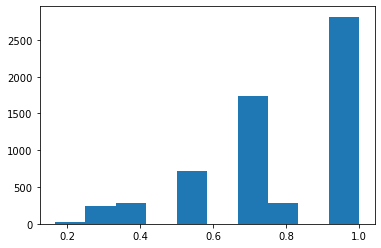

In [3]:
# print("The rule is: `1` if there is at least one green light, `0` otherwise")
go_rule = lambda row: 1 if "go" in row["Annotation tag"] else 0
day_train_df["Classification"] = day_train_df.apply(go_rule, axis=1)
day_test_df["Classification"] = day_test_df.apply(go_rule, axis=1)
# print(day_train_df["Classification"].unique(), day_test_df["Classification"].unique())

train_go = {0:[], 1:[]}
positive_annotations_per_image = []
for filename in tqdm(unique_train_filenames):    
    annotations = []
    query = day_train_df.loc[day_train_df["Filename"] == filename]
    for j, annotation in query.iterrows():
        annotations.append(annotation["Classification"])
        
    if any(annotations):
        train_go[1].append(filename)
        positive_annotations_per_image.append(sum(annotations)/len(annotations))
    else:
        train_go[0].append(filename)

test_go = {0:[], 1:[]}
for filename in tqdm(unique_test_filenames):    
    annotations = []
    query = day_test_df.loc[day_test_df["Filename"] == filename]
    for j, annotation in query.iterrows():
        annotations.append(annotation["Classification"])
        
    if any(annotations):
        test_go[1].append(filename)
    else:
        test_go[0].append(filename)
        
print(f"Found {len(train_go[1])} positive, {len(train_go[0])} negative training samples")
print(f"Found {len(test_go[1])} positive, {len(test_go[0])} negative testing samples")
plt.hist(positive_annotations_per_image)

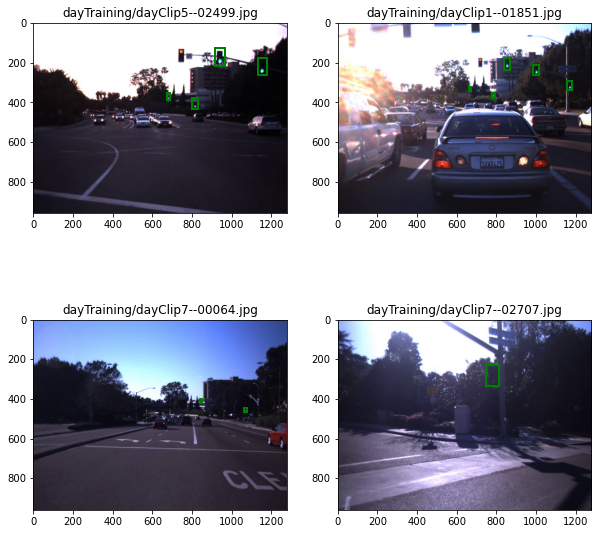

In [4]:
from torchvision import transforms
import matplotlib.patches as patches

fig = plt.figure(figsize=(10, 10))
axes = fig.subplots(2, 2)

t = transforms.ToTensor()

positive_example_filenames = np.random.choice(train_go[1], size=4, replace=False)
for i, example_filename in enumerate(positive_example_filenames):
    ax = axes[int(i/2), i%2]
    image_name = os.path.basename(example_filename)
    day_clip = image_name.split("--")[0]
    image_path = os.path.join(data_dir, "dayTrain", "dayTrain", day_clip, "frames", image_name)
    img = Image.open(image_path)
    img_t = t(img)
    ax.imshow(img_t.permute(1, 2, 0))
    annotations = day_train_df.loc[day_train_df["Filename"] == example_filename]
    for j, annotation in annotations.iterrows():
        if annotation["Classification"] == 1:
            upper_left_c = int(annotation["Upper left corner X"])
            upper_left_r = int(annotation["Upper left corner Y"])
            lower_right_c = int(annotation["Lower right corner X"])
            lower_right_r = int(annotation["Lower right corner Y"])
            w = np.abs(lower_right_c - upper_left_c)
            h = np.abs(lower_right_r - upper_left_r)
            rect = patches.Rectangle((upper_left_c, upper_left_r), w, h, linewidth=2, edgecolor="g", facecolor="none")
            ax.add_patch(rect)
            ax.set_title(example_filename)

In [6]:
from shutil import copyfile

stage_dict = {"train": train_go, "test": test_go}

for stage in ["train", "test"]:
    stage_go = stage_dict[stage]
    for _class in [0, 1]:
        for filename in tqdm(stage_go[_class]):
            image_name = os.path.basename(filename)
            clip_name = image_name.split("--")[0]
            
            if stage == "train":
                image_path = os.path.join(data_dir, "dayTrain", "dayTrain", clip_name, "frames", image_name)
            if stage == "test":
                image_path = os.path.join(data_dir, clip_name, clip_name, "frames", image_name)
                
            dest_path = os.path.join(datasets_dir, stage, str(_class), image_name)
            
            copyfile(image_path, dest_path)

100%|██████████| 3846/3846 [00:01<00:00, 2385.68it/s]
